<a href="https://colab.research.google.com/github/armandordorica/Portfolio_Optimization/blob/master/RegressionChannelWReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
cd drive/My\ Drive/u\ of\ t/APS\ 1051\ Portfolio\ Optimization/Session\ 6

/content/drive/My Drive/u of t/APS 1051 Portfolio Optimization/Session 6


In [6]:
cd  REGRESSIONCHANNELSINGLEASSETPROGRAMS/

/content/drive/My Drive/u of t/APS 1051 Portfolio Optimization/Session 6/REGRESSIONCHANNELSINGLEASSETPROGRAMS


In [7]:
ls

1.Introduction/  2.MoreAdvanced/


In [8]:
cd 2.MoreAdvanced/

/content/drive/My Drive/u of t/APS 1051 Portfolio Optimization/Session 6/REGRESSIONCHANNELSINGLEASSETPROGRAMS/2.MoreAdvanced


In [9]:
ls

detrendPrice.py  RegressionChannelWReg_GUIDE.mp3  Results/
functions.py     RegressionChannelWReg_GUIDE.txt  Untitled0.ipynb
IYE.csv          RegressionChannelWReg.pptx       WhiteRealityCheckFor1.py
__pycache__/     RegressionChannelWReg.py


In [11]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=f43e4703fb9531e95c73436c13690e4033bc0940c15e95123de692f7ffa1d26b
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [12]:
# -*- coding: utf-8 -*-
"""
SEE RegressionChannelWReg.pptx
SEE RegressionChannelWReg_GUIDE.txt
SEE RegressionChannelWReg_GUIDE.mp3

"""
import functions as ff
import matplotlib.pyplot as plt
from numpy import log, polyfit, sqrt, std, subtract
from datetime import datetime
import pandas as pd
import numpy as np
pd.core.common.is_list_like = pd.api.types.is_list_like #datareader problem probably fixed in next version of datareader
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
import detrendPrice
import WhiteRealityCheckFor1

start_date = '2000-01-01' 
end_date = '2019-06-01'
#end_date = datetime.now() 


* Below is the I-Y-E ETF, the iShares Dow Jones US Energy Sector ETF.
* This is a particularly volatile ETF, as the prices of oil suffer violent changes.

* `entryZScore = 2` - Sets the gauge of the regression channel to 2 standard deviations at either side of the mean.
  * The reason for this wide gauge is the extremely high volatility of the I=Y-E ETF.
  * Setting the entryZscore depends on two conditions, the first being the risk tolerance of the user, the lower the entryZscore, the more risk-tolerant.
  * The second condition is the actual dispersion of the price movement, which needs to be large enough for the selected `entryZscore`.

In [13]:

symbol = 'IYE' 
entryZscore = 2 # gauge of regression channel



# `exitZscore` Sets the exit of all trades to the center of the regression channel.


In [16]:
exitZscore = -.0


**This is the lookback window for all calculations.**

* To avoid the standard deviation from whiplashing too much,
a long enough window is recommended. 40 is the minimum for this.

In [ ]:

window = 40 #lookback for moving average or regression #40
shorts = 0 #shorts possible or not
regression = 1 # regression or moving average in the calculation of the Z-value
complex_entrance = 0 #2 day criterium for entering a position
forbidden = 0 #area of Z-value where no trades should be open
delay = 1 #1 for instant execution, 2 for one day delay
log_price = 1 #use the log of price for the calculation of Z input
tcost=10/10000*0


In [14]:


msg = "" 
address = symbol + '.csv'
  

try:
    dfP = pdr.get_data_yahoo(symbol, start=start_date, end=end_date)
    dfP.to_csv(address, header = True, index=True, encoding='utf-8')
except Exception:
    msg = "yahoo problem"
    dfP = pd.DataFrame()

dfP = pd.read_csv(address, parse_dates=['Date'])
dfP = dfP.sort_values(by='Date')
dfP.set_index('Date', inplace = True)


[*********************100%***********************]  1 of 1 completed


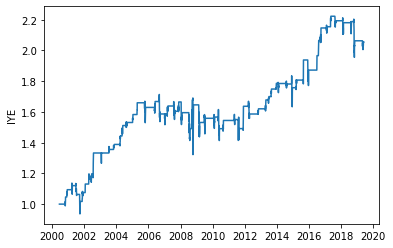

TotaAnnReturn = 5.485891
CAGR = 3.816417
Sharpe Ratio = 0.410000
average return 0.000305
[-0.00047545  0.00048937]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.1028


'\ndf = pd.read_csv(address, parse_dates=[\'Date\'])\ndf = df.sort_values(by=\'Date\')\ndf.set_index(\'Date\', inplace = True)\ndf = pd.DataFrame(data=df["Adj Close"], index=df.index)\narr = np.array(df[\'Adj Close\'].values)\n'

In [18]:

#dfP['Adj Close'].plot()
#plt.show()

dfP = dfP.assign(LOG_ADJ_CLOSE = np.log(dfP['Adj Close'])) 
dfP = dfP.assign(TIME = pd.Series(np.arange(dfP.shape[0])).values) 

if log_price == 1:
    price_column = 'LOG_ADJ_CLOSE'
else:
    price_column = 'Adj Close'

#rolling regression instead of moving average
a = np.array([np.nan] * len(dfP))
b = [np.nan] * len(dfP)  # If betas required.
y_ = dfP[price_column].values
x_ = dfP[['TIME']].assign(constant=1).values
for n in range(window, len(dfP)):
    y = y_[(n - window):n]
    X = x_[(n - window):n]
    # betas = Inverse(X'.X).X'.y
    betas = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
    y_hat = betas.dot(x_[n, :])
    a[n] = y_hat
    b[n] = betas.tolist()  # If betas required.

dfP = dfP.assign(y_hat = pd.Series(a).values)
    
if regression == 1:
    mean = dfP['y_hat']
else:
    mean = dfP[price_column].rolling(window=window).mean()

std_dev = dfP[price_column].rolling(window=window).std()
dfP['zScore'] = (dfP[price_column]-mean)/std_dev
dfP['mean'] = mean
dfP['stdev'] = std_dev
dfP['LB'] = mean - entryZscore*std_dev
dfP['UB'] = mean + entryZscore*std_dev


#dfP['zScore'].plot()
#plt.show()

#set up num_units_long  
if complex_entrance == 1:           
    dfP['long_entry'] = ((dfP.zScore > - entryZscore) & ( dfP.zScore.shift(1) < - entryZscore)) 
    dfP['long_exit'] = ((dfP.zScore < - exitZscore) & (dfP.zScore.shift(1) > - exitZscore)) 
else:
    dfP['long_entry'] = ((dfP.zScore <  -entryZscore))
    dfP['long_exit'] = ((dfP.zScore >  -exitZscore))


dfP = dfP.assign(long_forbidden = pd.Series(np.zeros(dfP.shape[0])).values)
dfP.loc[(dfP.zScore < - (entryZscore+1)) & (dfP.zScore.shift(1) > - (entryZscore+1)),'long_forbidden'] = 1 


dfP['num_units_long'] = np.nan #it is important to start with nan in this column otherwise padding wont work
dfP.loc[dfP['long_entry'],'num_units_long'] = 1 
dfP.loc[dfP['long_exit'],'num_units_long'] = 0 
if forbidden == 1:
    dfP.loc[dfP['long_forbidden']==1, 'num_units_long']= 0   
dfP.iat[0,dfP.columns.get_loc("num_units_long")]= 0
dfP['num_units_long'] = dfP['num_units_long'].fillna(method='pad') 

#set up num units short 
if complex_entrance == 1:
    dfP['short_entry'] = ((dfP.zScore <  entryZscore) & ( dfP.zScore.shift(1) > entryZscore))
    dfP['short_exit'] = ((dfP.zScore > exitZscore) & (dfP.zScore.shift(1) < exitZscore))
else:
    dfP['short_entry'] = ((dfP.zScore >  entryZscore))
    dfP['short_exit'] = ((dfP.zScore <  exitZscore))


dfP = dfP.assign(short_forbidden = pd.Series(np.zeros(dfP.shape[0])).values)
dfP.loc[(dfP.zScore >  entryZscore+1) & (dfP.zScore.shift(1) <  entryZscore+1),'short_forbidden'] = 1 

dfP['num_units_short'] = np.nan 
dfP.loc[dfP['short_entry'],'num_units_short'] = -1 
dfP.loc[dfP['short_exit'],'num_units_short'] = 0
if forbidden == 1:
    dfP.loc[dfP['short_forbidden']==1, 'num_units_short']= 0 
dfP.iat[0,dfP.columns.get_loc("num_units_short")]= 0
dfP['num_units_short'] = dfP['num_units_short'].fillna(method='pad')
dfP['num_units'] = dfP['num_units_long']*(1-tcost) +  dfP['num_units_short']*shorts*(1-tcost)

#log return calculation & cummulative return
#dfP['log_rets'] = np.log(dfP['Adj Close']/dfP['Adj Close'].shift(1))
#dfP['port_rets'] = dfP['log_rets'] * dfP['num_units'].shift(2) 
#dfP['cum_rets'] = dfP['log_rets'].cumsum()
#dfP['cum_rets'] = dfP['cum_rets'] + 1

#pct return calculation & cummulative return
dfP['pct_ch'] = (dfP['Adj Close']-dfP['Adj Close'].shift(1))/abs(dfP['Adj Close'].shift(1)) 
dfP['port_rets'] = dfP['pct_ch'] * dfP['num_units'].shift(delay) 
dfP = dfP.assign(I =np.cumprod(1+dfP['port_rets'])) 
dfP.iat[0,dfP.columns.get_loc('I')]= 1

title=symbol
plt.plot(dfP['I'])
plt.ylabel(symbol)
plt.show()
#plt.savefig(r'Results\%s.png' %(title))
#plt['Close']()

start = 1
start_val = start
end_val = dfP['I'].iat[-1]

start_date = dfP.iloc[0].name
end_date = dfP.iloc[-1].name
days = (end_date - start_date).days    

#for daily data
periods = 360 #360
trading_periods = 272 #252

TotaAnnReturn = (end_val-start_val)/start_val/(days/periods)
TotaAnnReturn_trading = (end_val-start_val)/start_val/(days/trading_periods)

years = days/periods
CAGR = ((end_val/start_val)**(1/years))-1


try:
    sharpe =  (dfP['port_rets'].mean()/ (dfP['port_rets'].std()) * np.sqrt(periods))
except ZeroDivisionError:
    sharpe = 0.0

print ("TotaAnnReturn = %f" %(TotaAnnReturn*100))
print ("CAGR = %f" %(CAGR*100))
print ("Sharpe Ratio = %f" %(round(sharpe,2)))

#Detrending Prices and Returns and white reality check
dfP['Det_Adj_Close'] = detrendPrice.detrendPrice(dfP['Adj Close']).values
dfP['Det_pct_ch'] = (dfP['Det_Adj_Close']-dfP['Det_Adj_Close'].shift(1))/abs(dfP['Det_Adj_Close'].shift(1)) 
dfP['Det_port_rets'] = dfP['Det_pct_ch'] * dfP['num_units'].shift(delay) 
WhiteRealityCheckFor1.bootstrap(dfP['Det_port_rets'])


dfP.to_csv(r'Results\dfP.csv', header = True, index=True, encoding='utf-8')

"""
df = pd.read_csv(address, parse_dates=['Date'])
df = df.sort_values(by='Date')
df.set_index('Date', inplace = True)
df = pd.DataFrame(data=df["Adj Close"], index=df.index)
arr = np.array(df['Adj Close'].values)
"""


**The following two functions are used to determine if shorts are possible**

In [ ]:

#the following two functions are used to determine if shorts are possible
arr= dfP["Adj Close"][-800:].values #need at least 800

ro = ff.vratio(arr, lag = 5, cor = 'hom')
print ('vratio =',ro[0])  
print ('zscore =',ro[1]) 
print ('pval =', ro[2]) 
print("If series is a random walk, vratio = 1")
print("If vratio != 1, e.g. .4 (<1) and zscore is greater than 1.64 for 1-tailed @ 95% cert, series is probably mean reverting")
print("If vratio != 1, e.g. 1.2 (>1) and zscore greater than 1.64  for 1-tailed @ 95% cert, probably a persistent series")
#When the v-ratio is less than one, the p-val ouput captures the significance level, you want it to be low, 10% or less.
#When the v-ratio is more than one, the p-val ouput captures the confidence level (oddly enough), you want it to be high, 90% or more.


### **V-ratio and mean reverting**
* If the vratio test confirms the series could be mean reverting, it makes sense to look at the halflife of the series.
* `halflife` multiplied by 2 tells us how long to wait till the process reaches the long term mean. 
* The halflife is one of the few ways we have of estimating a reasonable lookback window.
  * Needs to have as input the prices or the residuals or the difference of the logs of the prices (i.e.log returns)

If the series is mean reverting, you can set the lookback (=window, line 25) to a small multiple of the halflife.
For now, keep shorts = 0.

In [ ]:


halflife = ff.half_life(arr)
print ("\nHalflife = %f" %halflife)


